<a href="https://colab.research.google.com/github/pizzapasit/NVidia_Tacotron2_Waveglow_demo_test/blob/main/NVidia_Tacotron2_Waveglow_demo_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-to-Speech with Tacotron2 and Waveglow

This is an English female voice TTS demo using open source projects [NVIDIA/tacotron2](https://github.com/NVIDIA/tacotron2) and [NVIDIA/waveglow](https://github.com/NVIDIA/waveglow).



## Install Tacotron2 and Waveglow

In [ ]:
#@title
%tensorflow_version 1.x
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 9168aea
  !pip install -q librosa unidecode
  !pip install -q --upgrade gdown
  
import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import gdown
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

In [ ]:
!nvidia-smi -L
!nvidia-smi

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fa3ca076-7d20-ed5a-3cf6-e3ca6d1ed20b)
Thu May 12 12:51:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   4405MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
           

## Download pretrained models

In [ ]:
#@title
tacotron2_pretrained_model = 'tacotron2_statedict.pt'
if not exists(tacotron2_pretrained_model):
  # download the Tacotron2 pretrained model
  gdown.download('https://drive.google.com/uc?id=1-Bfx-NE-8tUdwUMF8h9w_OmyofqXMoMF', tacotron2_pretrained_model, quiet=False)
waveglow_pretrained_model = 'waveglow_old.pt'
if not exists(waveglow_pretrained_model):
  # download the Waveglow pretrained model  
  gdown.download('https://drive.google.com/uc?id=1-Bfx-NE-8tUdwUMF8h9w_OmyofqXMoMF', waveglow_pretrained_model, quiet=False)

In [ ]:
#waveglow_path = 'waveglow_256channels.pt'
#waveglow = torch.load(waveglow_path)['model']
#waveglow_old.pt

## Initialize Tacotron2 and Waveglow

Following code is copied from https://github.com/NVIDIA/tacotron2/blob/master/inference.ipynb and updated for the Colab.

In [ ]:
#@title
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser


torch.set_grad_enabled(False)
        
# initialize Tacotron2 with the pretrained model
hparams = create_hparams()
hparams.sampling_rate = 22050
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval()#.half()

# initialize Waveglow with the pretrained model
# waveglow = torch.load(waveglow_pretrained_model)['model']
# WORKAROUND for: https://github.com/NVIDIA/tacotron2/issues/182
import json
from glow import WaveGlow
waveglow_config = json.load(open('%s/waveglow/config.json' % project_name))['waveglow_config']
waveglow = WaveGlow(**waveglow_config)
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', trust_repo=True, model_math='fp32')
_ = waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


## Synthesize a text

Replace `TEXT` with your text if you want try out another text.

In [ ]:
model = model.to('cuda')
model.eval()

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

In [ ]:
!apt-get update
!apt-get install -y libsndfile1

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 2s (130 kB/s)
Reading package lis

Now convert the text into mel spectrogram using Tacotron2 and plot it:

Finally, we can convert the generated mel spectrogram into an audio:

In [ ]:
graph_width = 900
graph_height = 360
def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='inferno')
    fig.canvas.draw()
    plt.show()

In [ ]:
TEXT1 = "How much variation is there."
sequences1, lengths1 = utils.prepare_input_sequence([TEXT1])


with torch.no_grad():
    mel1, mel_outputs_postnet1, _, alignments1 = model.inference(sequences1)
    audio1 = waveglow.infer(mel1)
audio_numpy1 = audio1[0].data.cpu().numpy()
rate = 22050


ipd.Audio(audio_numpy1, rate=rate)

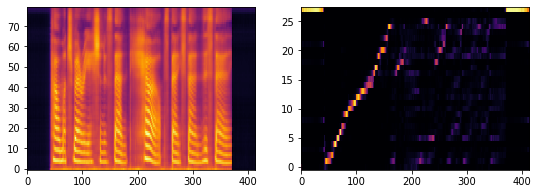

In [ ]:
plot_data((mel1.float().data.cpu().numpy()[0], alignments1.float().data.cpu().numpy()[0].T))

In [ ]:
TEXT2 = "It is well known that deep generative models have a rich latent space"
sequences2, lengths2 = utils.prepare_input_sequence([TEXT2])


with torch.no_grad():
    mel2, mel_outputs_postnet2, _, alignments2 = model.inference(sequences2)
    audio2 = waveglow.infer(mel2)
audio_numpy2 = audio2[0].data.cpu().numpy()
rate = 22050


ipd.Audio(audio_numpy2, rate=rate)

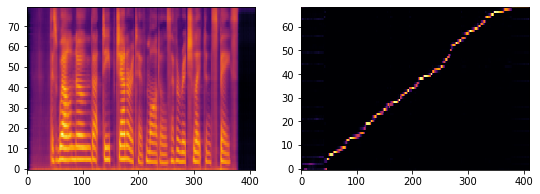

In [ ]:
plot_data((mel2.float().data.cpu().numpy()[0], alignments2.float().data.cpu().numpy()[0].T))

In [ ]:
TEXT3 = "We are testing this model"
sequences3, lengths3 = utils.prepare_input_sequence([TEXT3])


with torch.no_grad():
    mel3, mel_outputs_postnet3, _, alignments3 = model.inference(sequences3)
    audio3 = waveglow.infer(mel3)
audio_numpy3 = audio3[0].data.cpu().numpy()
rate = 22050


ipd.Audio(audio_numpy3, rate=rate)

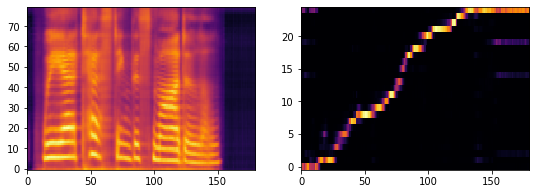

In [ ]:
plot_data((mel3.float().data.cpu().numpy()[0], alignments3.float().data.cpu().numpy()[0].T))

In [ ]:
TEXT4 = "This idea."
sequences4, lengths4 = utils.prepare_input_sequence([TEXT4])


with torch.no_grad():
    mel4, mel_outputs_postnet4, _, alignments4 = model.inference(sequences4)
    audio4 = waveglow.infer(mel4)
audio_numpy4 = audio4[0].data.cpu().numpy()
rate = 22050


ipd.Audio(audio_numpy4, rate=rate)

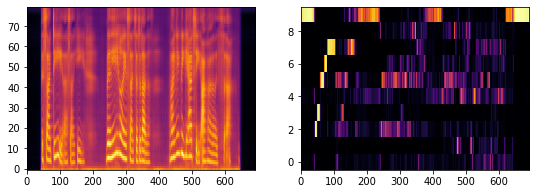

In [ ]:
plot_data((mel4.float().data.cpu().numpy()[0], alignments4.float().data.cpu().numpy()[0].T))

In [ ]:
TEXT5 = "Shaking my hair from my eyes."
sequences5, lengths5 = utils.prepare_input_sequence([TEXT5])


with torch.no_grad():
    mel5, mel_outputs_postnet5, _, alignments5 = model.inference(sequences5)
    audio5 = waveglow.infer(mel5)
audio_numpy5 = audio5[0].data.cpu().numpy()
rate = 22050


ipd.Audio(audio_numpy5, rate=rate)

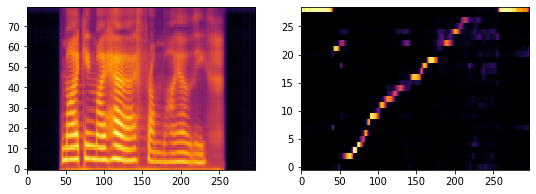

In [ ]:
plot_data((mel5.float().data.cpu().numpy()[0], alignments5.float().data.cpu().numpy()[0].T))

In [ ]:
TEXT6 = "at this moment a light gleamed on the wall Was it."
sequences6, lengths6 = utils.prepare_input_sequence([TEXT6])


with torch.no_grad():
    mel6, mel_outputs_postnet6, _, alignments6 = model.inference(sequences6)
    audio6 = waveglow.infer(mel6)
audio_numpy6 = audio6[0].data.cpu().numpy()
rate = 22050


ipd.Audio(audio_numpy6, rate=rate)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

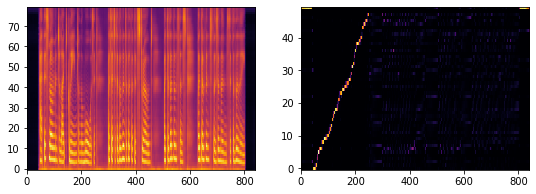

In [ ]:
plot_data((mel6.float().data.cpu().numpy()[0], alignments6.float().data.cpu().numpy()[0].T))

In [ ]:
TEXT7 = "No moonlight was still."
sequences7, lengths7 = utils.prepare_input_sequence([TEXT7])


with torch.no_grad():
    mel7, mel_outputs_postnet7, _, alignments7 = model.inference(sequences7)
    audio7 = waveglow.infer(mel7)
audio_numpy7 = audio7[0].data.cpu().numpy()
rate = 22050


ipd.Audio(audio_numpy7, rate=rate)

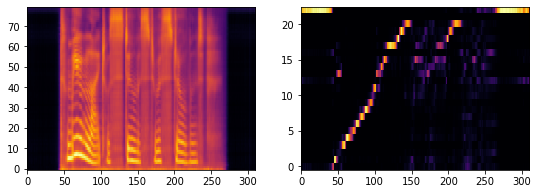

In [ ]:
plot_data((mel7.float().data.cpu().numpy()[0], alignments7.float().data.cpu().numpy()[0].T))

In [ ]:
TEXT8 = "I can now conjecture readily that this streak of light was."
sequences8, lengths8 = utils.prepare_input_sequence([TEXT8])


with torch.no_grad():
    mel8, mel_outputs_postnet6, _, alignments8 = model.inference(sequences8)
    audio8 = waveglow.infer(mel8)
audio_numpy8 = audio8[0].data.cpu().numpy()
rate = 22050


ipd.Audio(audio_numpy8, rate=rate)

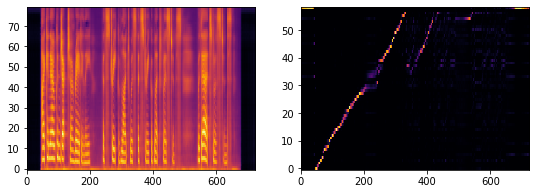

In [ ]:
plot_data((mel8.float().data.cpu().numpy()[0], alignments8.float().data.cpu().numpy()[0].T))

In [ ]:
TEXT9 = "prepared as my mind was for horror."
sequences9, lengths9 = utils.prepare_input_sequence([TEXT9])


with torch.no_grad():
    mel9, mel_outputs_postnet9, _, alignments9 = model.inference(sequences9)
    audio9 = waveglow.infer(mel9)
audio_numpy9 = audio9[0].data.cpu().numpy()
rate = 22050


ipd.Audio(audio_numpy9, rate=rate)

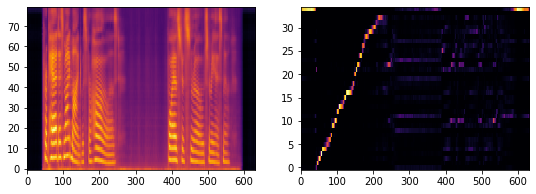

In [ ]:
plot_data((mel9.float().data.cpu().numpy()[0], alignments9.float().data.cpu().numpy()[0].T))

In [ ]:
TEXT10 = "My heart beat thick."
sequences10, lengths10 = utils.prepare_input_sequence([TEXT10])


with torch.no_grad():
    mel10, mel_outputs_postnet10, _, alignments10 = model.inference(sequences10)
    audio10 = waveglow.infer(mel10)
audio_numpy10 = audio10[0].data.cpu().numpy()
rate = 22050


ipd.Audio(audio_numpy10, rate=rate)

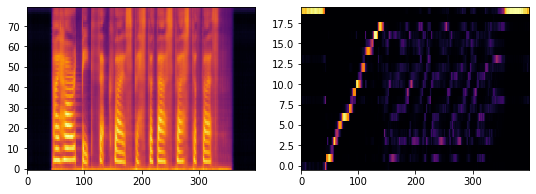

In [ ]:
plot_data((mel10.float().data.cpu().numpy()[0], alignments10.float().data.cpu().numpy()[0].T))